# Movie Recommendation System

## Environment settings preparation

In [1]:
# Dataset
import pandas as pd

# Pytorch geometric
import torch

# My scripts
from Src.scripts.data.tabular_dataset_handler import TabularDatasetHandler
from Src.scripts.data.graph_dataset_handler import HeterogeneousGraphDatasetHandler
from Src.scripts.approaches.collaborative_filters.GNN_based_CF import GNN_Based_CollaborativeFilter
from Src.scripts.approaches.models.GNN_regression_model import GCNEncoder, GraphSAGEEncoder, GATEncoder
from Src.scripts.approaches.filters.hybrid_filtering import HybridFiltering

# Remove warnings
import warnings; warnings.simplefilter('ignore')

In [2]:
# Check if CUDA is available:
if torch.cuda.is_available():
    print("CUDA is available.")
    
    # Get the number of available GPUs:
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
    
    # Get information about each GPU:
    for i in range(torch.cuda.device_count()):
        gpu = torch.cuda.get_device_properties(i)
        print(f"GPU {i}: {gpu.name}, Compute Capability: {gpu.major}.{gpu.minor}")
    
    # Get the currently selected GPU:
    current_gpu = torch.cuda.current_device()
    print(f"Currently selected GPU number: {current_gpu}")
else:
    print("CUDA is not available.")

CUDA is available.
Number of GPUs available: 1
GPU 0: NVIDIA GeForce GTX 970, Compute Capability: 5.2
Currently selected GPU number: 0


# Tabular dataset preparation

## Data loading

In [3]:
tdh = TabularDatasetHandler()
tdh.get_movies_df_deepcopy().shape

(45466, 24)

In [4]:
tdh.get_movies_df_deepcopy().head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [5]:
tdh.get_movies_df_deepcopy().dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

## Data preprocessing

In [6]:
tdh.preprocess_datasets()
tdh.get_movies_df_deepcopy().shape

(45463, 25)

In [7]:
tdh.get_movies_df_deepcopy().head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
0,False,Toy Story Collection,30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995
1,False,None,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995
2,False,Grumpy Old Men Collection,0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995
3,False,None,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995
4,False,Father of the Bride Collection,0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995


In [8]:
tdh.get_movies_df_deepcopy().dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                         int32
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
year                      object
dtype: object

# Collaborative filtering: GNN-based

## Create a new user to suggest movies to

In [9]:
from Src.scripts.approaches.filters.popularity_rankings import PopularityRanking

users_ratings_df = tdh.get_users_ratings_df_deepcopy()
movies_df = tdh.get_small_movies_df_deepcopy()

# Create a new user
new_user_id = users_ratings_df['userId'].max() + 1

# Popularity Ranking in this case is one good possible solution to solve the cold-start problem
print('Most rated movies:')
most_rated_movies = PopularityRanking.top_movies_IMDB_wr_formula(tdh, 15)
most_rated_movies = most_rated_movies[['id', 'title']].set_index('id')
print(most_rated_movies)

# Initialize the movies ratings list
ratings = []

Most rated movies:
                                                    title
id                                                       
19404                         Dilwale Dulhania Le Jayenge
27205                                           Inception
155                                       The Dark Knight
157336                                       Interstellar
550                                            Fight Club
120     The Lord of the Rings: The Fellowship of the Ring
680                                          Pulp Fiction
278                              The Shawshank Redemption
122         The Lord of the Rings: The Return of the King
13                                           Forrest Gump
121                 The Lord of the Rings: The Two Towers
11                                              Star Wars
105                                    Back to the Future
238                                         The Godfather
1891                              The Empire Strikes 

In [10]:
# Set the new_user's ratings for the 'most_rated_movies', to avoid the cold-start problem
ratings.append({'movieId': 19404, 'rating': 1.5, 'userId': new_user_id})
ratings.append({'movieId': 27205, 'rating': 2, 'userId': new_user_id})
ratings.append({'movieId': 155, 'rating': 3.5, 'userId': new_user_id})
ratings.append({'movieId': 157336, 'rating': 3, 'userId': new_user_id})
ratings.append({'movieId': 550, 'rating': 3, 'userId': new_user_id})
ratings.append({'movieId': 120, 'rating': 5, 'userId': new_user_id})
ratings.append({'movieId': 680, 'rating': 2, 'userId': new_user_id})
ratings.append({'movieId': 278, 'rating': 1.5, 'userId': new_user_id})
ratings.append({'movieId': 122, 'rating': 5, 'userId': new_user_id})
ratings.append({'movieId': 13, 'rating': 5, 'userId': new_user_id})
ratings.append({'movieId': 121, 'rating': 5, 'userId': new_user_id})
ratings.append({'movieId': 11, 'rating': 2.5, 'userId': new_user_id})
ratings.append({'movieId': 105, 'rating': 3.5, 'userId': new_user_id})
ratings.append({'movieId': 238, 'rating': 3.5, 'userId': new_user_id})
ratings.append({'movieId': 1891, 'rating': 2.5, 'userId': new_user_id})
ratings

[{'movieId': 19404, 'rating': 1.5, 'userId': 672},
 {'movieId': 27205, 'rating': 2, 'userId': 672},
 {'movieId': 155, 'rating': 3.5, 'userId': 672},
 {'movieId': 157336, 'rating': 3, 'userId': 672},
 {'movieId': 550, 'rating': 3, 'userId': 672},
 {'movieId': 120, 'rating': 5, 'userId': 672},
 {'movieId': 680, 'rating': 2, 'userId': 672},
 {'movieId': 278, 'rating': 1.5, 'userId': 672},
 {'movieId': 122, 'rating': 5, 'userId': 672},
 {'movieId': 13, 'rating': 5, 'userId': 672},
 {'movieId': 121, 'rating': 5, 'userId': 672},
 {'movieId': 11, 'rating': 2.5, 'userId': 672},
 {'movieId': 105, 'rating': 3.5, 'userId': 672},
 {'movieId': 238, 'rating': 3.5, 'userId': 672},
 {'movieId': 1891, 'rating': 2.5, 'userId': 672}]

## Graph dataset construction

In [11]:
# Define a graph dataset
gdh = HeterogeneousGraphDatasetHandler(preprocessed_tdh=tdh)

In [12]:
# Add the new user and its ratings to the graph dataset
updated_users_ratings_df = gdh.users_ratings_df
print("Number of rating records before updating", len(gdh.users_ratings_df))
gdh.add_users_ratings_data(pd.DataFrame.from_records(ratings))
print("Number of rating records after updating", len(gdh.users_ratings_df))

Number of rating records before updating 100004
Number of rating records after updating 100019


In [13]:
# Build the graph dataset
gdh.build_graph_dataset()
dataset = gdh.get_graph_dataset()

In [14]:
dataset

HeteroData(
  user={
    node_id=[672],
    x=[672, 672],
  },
  movie={
    node_id=[9099],
    x=[9099, 404],
  },
  (user, rating, movie)={
    edge_index=[2, 100019],
    edge_label=[100019],
    y=[100019],
  },
  (movie, rev_rating, user)={
    edge_index=[2, 100019],
    y=[100019],
  }
)

In [15]:
# Print dataset information
print("Dataset size: ", dataset.size())
print("\nDataset type: ", type(dataset))
print("\nDataset metadata: ", dataset.metadata())
print("\nDataset to dict: ", dataset.to_dict())

Dataset size:  (9771, 9771)

Dataset type:  <class 'torch_geometric.data.hetero_data.HeteroData'>

Dataset metadata:  (['user', 'movie'], [('user', 'rating', 'movie'), ('movie', 'rev_rating', 'user')])

Dataset to dict:  {'_global_store': {}, 'user': {'node_id': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 13

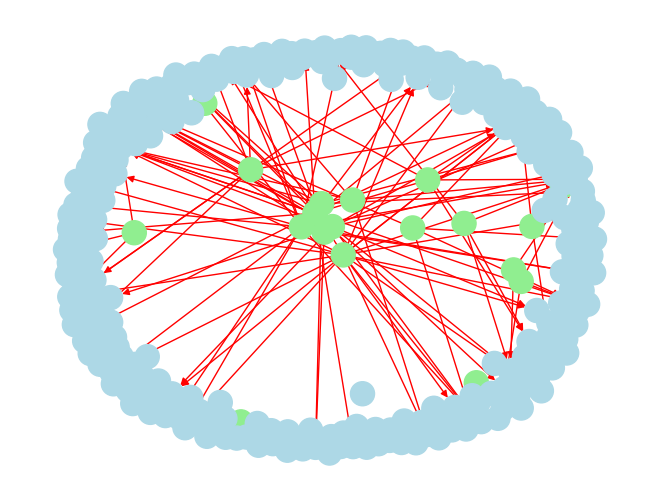

In [16]:
# Visualize a sampled (sub)graph dataset (for better visualization reasons)
gdh.plot_graph_dataset(node_sample_ratio=0.03, with_labels=False)

In [17]:
# Save the dataset locally on disk
#gdh.save_graph_dataset()

In [18]:
# Load the dataset from disk
#dataset = gdh.load_graph_dataset()
#dataset

## GNN models training and evaluation

### GCN

In [19]:
GCN_movie_suggestor = GNN_Based_CollaborativeFilter(
    graph_dataset_handler=gdh,
    gnn_encoder=GCNEncoder(hidden_channels=64, out_channels=64)
)

In [20]:
GCN_movie_suggestor.train(num_epochs=500, lr=0.001)

Device: 'cuda
'
Epoch: 001, Train loss: 10.9432, Train RMSE: 1.7981, Train MAE: 1.4545, Val RMSE: 1.8176, Val MAE: 1.4741
Epoch: 002, Train loss: 4282.3594, Train RMSE: 1.7958, Train MAE: 1.4536, Val RMSE: 1.8160, Val MAE: 1.4730
Epoch: 003, Train loss: 357.6802, Train RMSE: 3.6982, Train MAE: 3.5438, Val RMSE: 3.6580, Val MAE: 3.4960
Epoch: 004, Train loss: 293.5372, Train RMSE: 3.6989, Train MAE: 3.5445, Val RMSE: 3.6851, Val MAE: 3.5281
Epoch: 005, Train loss: 772.8289, Train RMSE: 3.6988, Train MAE: 3.5444, Val RMSE: 3.6806, Val MAE: 3.5233
Epoch: 006, Train loss: 585.7818, Train RMSE: 3.6850, Train MAE: 3.5286, Val RMSE: 3.6078, Val MAE: 3.4227
Epoch: 007, Train loss: 203.4606, Train RMSE: 3.3660, Train MAE: 3.1410, Val RMSE: 3.3101, Val MAE: 3.0706
Epoch: 008, Train loss: 13.2271, Train RMSE: 1.7571, Train MAE: 1.4198, Val RMSE: 1.7723, Val MAE: 1.4336
Epoch: 009, Train loss: 51.0769, Train RMSE: 1.7652, Train MAE: 1.4264, Val RMSE: 1.7810, Val MAE: 1.4423
Epoch: 010, Train loss:

In [21]:
GCN_movie_suggestor.evaluate_performance()

Device: 'cuda
'
Test RMSE: 1.5314, Test MAE: 1.2127

       userId  movieId  pred_rating  gt_rating
0         310      876     4.394206        4.0
1         460     2710     5.000000        1.0
2         546     3968     5.000000        3.5
3         517     5650     4.359289        1.0
4         293      597     4.965607        5.0
...       ...      ...          ...        ...
9996      101     2148     3.873517        3.5
9997      315     1711     2.914897        3.0
9998      306     1500     3.014466        1.5
9999      536      782     4.943999        3.0
10000     647     8954     3.668745        4.0

[10001 rows x 4 columns]


### SAGEGraph

In [22]:
GraphSAGE_movie_suggestor = GNN_Based_CollaborativeFilter(
    graph_dataset_handler=gdh,
    gnn_encoder=GraphSAGEEncoder(hidden_channels=64, out_channels=64)
)

In [23]:
GraphSAGE_movie_suggestor.train(num_epochs=500)

Device: 'cuda
'
Epoch: 001, Train loss: 13.6436, Train RMSE: 3.3148, Train MAE: 3.1405, Val RMSE: 3.3203, Val MAE: 3.1486
Epoch: 002, Train loss: 10.9879, Train RMSE: 2.4350, Train MAE: 2.2340, Val RMSE: 2.4477, Val MAE: 2.2478
Epoch: 003, Train loss: 5.9291, Train RMSE: 1.0742, Train MAE: 0.8533, Val RMSE: 1.0791, Val MAE: 0.8597
Epoch: 004, Train loss: 1.1539, Train RMSE: 1.8034, Train MAE: 1.4584, Val RMSE: 1.7923, Val MAE: 1.4498
Epoch: 005, Train loss: 10.8939, Train RMSE: 1.4483, Train MAE: 1.1279, Val RMSE: 1.4293, Val MAE: 1.1130
Epoch: 006, Train loss: 2.0982, Train RMSE: 1.3122, Train MAE: 1.1178, Val RMSE: 1.3312, Val MAE: 1.1331
Epoch: 007, Train loss: 1.7219, Train RMSE: 1.9605, Train MAE: 1.7527, Val RMSE: 1.9772, Val MAE: 1.7703
Epoch: 008, Train loss: 3.8437, Train RMSE: 2.2551, Train MAE: 2.0524, Val RMSE: 2.2693, Val MAE: 2.0672
Epoch: 009, Train loss: 5.0855, Train RMSE: 2.3009, Train MAE: 2.0983, Val RMSE: 2.3147, Val MAE: 2.1128
Epoch: 010, Train loss: 5.2941, Trai

In [24]:
GraphSAGE_movie_suggestor.evaluate_performance()

Device: 'cuda
'
Test RMSE: 0.9913, Test MAE: 0.7748

       userId  movieId  pred_rating  gt_rating
0         528      165     3.422981        4.0
1         261     1260     3.554120        4.0
2         200       27     2.375737        2.0
3         471      740     3.513098        4.0
4         508     4695     3.312469        3.0
...       ...      ...          ...        ...
9996      653      129     3.967447        3.0
9997      451      216     4.426600        3.5
9998      312     1322     3.919653        4.0
9999      504      739     3.706846        3.0
10000     451     2758     3.069538        2.0

[10001 rows x 4 columns]


### GAT

In [25]:
GAT_movie_suggestor = GNN_Based_CollaborativeFilter(
    graph_dataset_handler=gdh,
    gnn_encoder=GATEncoder(hidden_channels=64, out_channels=64)
)

In [26]:
GAT_movie_suggestor.train(num_epochs=500)

Device: 'cuda
'
Epoch: 001, Train loss: 14.2571, Train RMSE: 3.4128, Train MAE: 3.2439, Val RMSE: 3.4325, Val MAE: 3.2706
Epoch: 002, Train loss: 11.6470, Train RMSE: 2.4927, Train MAE: 2.2924, Val RMSE: 2.5165, Val MAE: 2.3206
Epoch: 003, Train loss: 6.2135, Train RMSE: 1.0786, Train MAE: 0.8489, Val RMSE: 1.0682, Val MAE: 0.8444
Epoch: 004, Train loss: 1.1635, Train RMSE: 1.8044, Train MAE: 1.4602, Val RMSE: 1.7717, Val MAE: 1.4335
Epoch: 005, Train loss: 10.0231, Train RMSE: 1.3941, Train MAE: 1.0790, Val RMSE: 1.3580, Val MAE: 1.0537
Epoch: 006, Train loss: 1.9435, Train RMSE: 1.3408, Train MAE: 1.1504, Val RMSE: 1.3610, Val MAE: 1.1670
Epoch: 007, Train loss: 1.7978, Train RMSE: 1.9240, Train MAE: 1.7147, Val RMSE: 1.9490, Val MAE: 1.7425
Epoch: 008, Train loss: 3.7017, Train RMSE: 2.1615, Train MAE: 1.9588, Val RMSE: 2.1862, Val MAE: 1.9866
Epoch: 009, Train loss: 4.6722, Train RMSE: 2.1451, Train MAE: 1.9422, Val RMSE: 2.1697, Val MAE: 1.9699
Epoch: 010, Train loss: 4.6013, Trai

In [27]:
GAT_movie_suggestor.evaluate_performance()

Device: 'cuda
'
Test RMSE: 1.0445, Test MAE: 0.8200

       userId  movieId  pred_rating  gt_rating
0         411      521     3.582801        5.0
1         357      141     3.242698        2.0
2         277      551     3.120617        3.0
3         242      196     3.477158        4.0
4         242      165     3.495454        2.0
...       ...      ...          ...        ...
9996      663     1781     3.916698        3.0
9997      184     2275     4.003401        5.0
9998      653     3119     3.362052        3.0
9999      290      362     3.606582        3.0
10000     471      186     3.837898        5.0

[10001 rows x 4 columns]


In [28]:
# MY COMMENT: RMSE = 1 means that the mean error on rating predictions is around [-1, +1] 
# on a rate that goes from [1, 5] 

## Movie prediction

In [29]:
print("Ground truth ratings of new_user:")
ratings

Ground truth ratings of new_user:


[{'movieId': 19404, 'rating': 1.5, 'userId': 672},
 {'movieId': 27205, 'rating': 2, 'userId': 672},
 {'movieId': 155, 'rating': 3.5, 'userId': 672},
 {'movieId': 157336, 'rating': 3, 'userId': 672},
 {'movieId': 550, 'rating': 3, 'userId': 672},
 {'movieId': 120, 'rating': 5, 'userId': 672},
 {'movieId': 680, 'rating': 2, 'userId': 672},
 {'movieId': 278, 'rating': 1.5, 'userId': 672},
 {'movieId': 122, 'rating': 5, 'userId': 672},
 {'movieId': 13, 'rating': 5, 'userId': 672},
 {'movieId': 121, 'rating': 5, 'userId': 672},
 {'movieId': 11, 'rating': 2.5, 'userId': 672},
 {'movieId': 105, 'rating': 3.5, 'userId': 672},
 {'movieId': 238, 'rating': 3.5, 'userId': 672},
 {'movieId': 1891, 'rating': 2.5, 'userId': 672}]

In [30]:
user_id = new_user_id
movie_id = 1891
pred_rating, gt_rating = GCN_movie_suggestor.predict(user_id, movie_id)

# Extract movie titles as a list
movie_titles = gdh.movies_df.loc[gdh.movies_df['id'] == movie_id, 'title'].tolist()

# Check if any titles were found
if movie_titles:
    movie_title = movie_titles[0]   # Display the first title
    print(f"Movie: {movie_title}, Pred rating: {pred_rating:.4f}, Ground truth rating: {gt_rating:.4f}")
else:
    print(f"No movie found with id {movie_id}")

Movie: The Empire Strikes Back, Pred rating: 0.8041, Ground truth rating: 2.5000


In [31]:
user_id = new_user_id
movie_id = 278
pred_rating, gt_rating = GraphSAGE_movie_suggestor.predict(user_id, movie_id)

# Extract movie titles as a list
movie_titles = gdh.movies_df.loc[gdh.movies_df['id'] == movie_id, 'title'].tolist()

# Check if any titles were found
if movie_titles:
    movie_title = movie_titles[0]   # Display the first title
    print(f"Movie: {movie_title}, Pred rating: {pred_rating:.4f}, Ground truth rating: {gt_rating:.4f}")
else:
    print(f"No movie found with id {movie_id}")

Movie: The Shawshank Redemption, Pred rating: 4.1136, Ground truth rating: 1.5000


In [32]:
user_id = 2
movie_id = 110
pred_rating, gt_rating = GAT_movie_suggestor.predict(user_id, movie_id)

# Extract movie titles as a list
movie_titles = gdh.movies_df.loc[gdh.movies_df['id'] == movie_id, 'title'].tolist()

# Check if any titles were found
if movie_titles:
    movie_title = movie_titles[0]   # Display the first title
    print(f"Movie: {movie_title}, Pred rating: {pred_rating:.4f}, Ground truth rating: {gt_rating:.4f}")
else:
    print(f"No movie found with id {movie_id}")

Movie: Three Colors: Red, Pred rating: 2.3842, Ground truth rating: 4.0000


## Movie suggestion

In [33]:
pred_movie_id, pred_rating = GraphSAGE_movie_suggestor.suggest_new_movie(new_user_id)
movie_title = pred_movie_id['title'].item()

print(f"New movie:  {movie_title}, Predicted rating: {pred_rating:.4f}")

New movie:  Batman & Robin, Predicted rating: 4.9464


# Hybrid filtering: GNN-based

## CGN

In [34]:
hybrid_movies_suggestor = HybridFiltering(tdh, GCN_movie_suggestor)
user_id = 1
movie_title = 'The Dark Knight'
hybrid_movies_suggestor.predict(user_id, movie_title, 25).head(10)

,id,title,year,soup,est_rating,gt_rating
3381,77,Memento,2000,guypearce carrie-annemoss joepantoliano christ...,3.752687,NaN
6218,272,Batman Begins,2005,christianbale michaelcaine liamneeson christop...,3.007505,NaN
7648,27205,Inception,2010,leonardodicaprio josephgordon-levitt ellenpage...,2.695839,NaN
1532,1051,The French Connection,1971,genehackman fernandorey royscheider williamfri...,2.603200,4.0
4145,320,Insomnia,2002,alpacino robinwilliams hilaryswank christopher...,1.947761,NaN
6623,1124,The Prestige,2006,hughjackman christianbale michaelcaine christo...,1.936158,NaN
8031,49026,The Dark Knight Rises,2012,christianbale michaelcaine garyoldman christop...,1.605446,NaN
8613,157336,Interstellar,2014,matthewmcconaughey jessicachastain annehathawa...,1.403532,NaN
149,10428,Hackers,1995,jonnyleemiller angelinajolie jessebradford iai...,1.364102,NaN
440,9516,Menace II Society,1993,tyrinturner larenztate glennplummer alberthugh...,1.158412,NaN


## GraphSAGE

In [35]:
hybrid_movies_suggestor = HybridFiltering(tdh, GraphSAGE_movie_suggestor)
user_id = 1
movie_title = 'The Dark Knight'
hybrid_movies_suggestor.predict(user_id, movie_title, 25).head(10)

,id,title,year,soup,est_rating,gt_rating
2639,9367,El Mariachi,1992,carlosgallardo jaimedehoyos petermarquardt rob...,4.485916,NaN
7648,27205,Inception,2010,leonardodicaprio josephgordon-levitt ellenpage...,4.371590,NaN
2952,10648,Magnum Force,1973,clinteastwood halholbrook mitchellryan tedpost...,4.034558,NaN
1952,16885,The General,1998,brendangleeson adriandunbar seanmcginley johnb...,3.841166,NaN
8031,49026,The Dark Knight Rises,2012,christianbale michaelcaine garyoldman christop...,3.739189,NaN
8613,157336,Interstellar,2014,matthewmcconaughey jessicachastain annehathawa...,3.718846,NaN
6218,272,Batman Begins,2005,christianbale michaelcaine liamneeson christop...,3.701414,NaN
1532,1051,The French Connection,1971,genehackman fernandorey royscheider williamfri...,3.676449,4.0
3864,17689,The Gauntlet,1977,clinteastwood sondralocke pathingle clinteastw...,3.654951,NaN
2772,2085,Romeo Must Die,2000,jetli aaliyah isaiahwashington andrzejbartkowi...,3.631895,NaN


## GAT

In [36]:
hybrid_movies_suggestor = HybridFiltering(tdh, GAT_movie_suggestor)
user_id = 1
movie_title = 'The Dark Knight'
hybrid_movies_suggestor.predict(user_id, movie_title, 25).head(10)

,id,title,year,soup,est_rating,gt_rating
7648,27205,Inception,2010,leonardodicaprio josephgordon-levitt ellenpage...,4.780433,NaN
149,10428,Hackers,1995,jonnyleemiller angelinajolie jessebradford iai...,4.309751,NaN
2952,10648,Magnum Force,1973,clinteastwood halholbrook mitchellryan tedpost...,4.247252,NaN
3864,17689,The Gauntlet,1977,clinteastwood sondralocke pathingle clinteastw...,4.052695,NaN
1952,16885,The General,1998,brendangleeson adriandunbar seanmcginley johnb...,4.006466,NaN
4145,320,Insomnia,2002,alpacino robinwilliams hilaryswank christopher...,3.996456,NaN
628,26744,Force of Evil,1948,johngarfield thomasgomez mariewindsor abrahamp...,3.995101,NaN
2772,2085,Romeo Must Die,2000,jetli aaliyah isaiahwashington andrzejbartkowi...,3.994118,NaN
2639,9367,El Mariachi,1992,carlosgallardo jaimedehoyos petermarquardt rob...,3.991994,NaN
6218,272,Batman Begins,2005,christianbale michaelcaine liamneeson christop...,3.937779,NaN
